# Infrared-Based Pressure Map Estimation for Pressure Ulcer Prevention

This work focuses on developing an artificial intelligence–based system to estimate pressure maps from infrared images, aiming to prevent pressure ulcers in patients who remain bedridden for extended periods. By first extracting the body skeleton from IR images using a Pose estimation model and then leveraging those skeletal features to infer accurate pressure maps, the system identifies early the critical areas where the body’s weight is concentrated, thereby enabling timely interventions to avoid these injuries. This approach offers a cost‑effective and efficient alternative to traditional methods, contributing to improved monitoring and care in hospital settings.

### IMPORTS:

First and foremost, I `import` all the libraries and modules required for my work and for creating my functions. This step involves including essential packages for data manipulation, mathematical computations, and any other functionalities that my code may depend on. By setting up these imports at the beginning, I ensure that all dependencies are readily available throughout the development process, thereby facilitating efficient coding and debugging.

In [1]:
import cv2
import os
import torch
import sys
import math

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.io import loadmat
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data._utils.collate import default_collate
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, zoom
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [2]:
REPO_PATH   = "/mnt/DADES/home/lchachoud/lightweight-human-pose-estimation.pytorch"
DATA_ROOT   = "/mnt/DADES/home/lchachoud/outputs/danaLab_rgb"
ORIG_ROOT   = "/mnt/DADES2/SLP/SLP/danaLab"

### PRACTICAL INSIGHT:

I decided to generate a set of visualizations to gain practical insight into how our joint annotations and IR images are organized. For each patient, I load the ground‑truth joint coordinates and gather the sorted file paths for the “cover1”, “cover2” and “uncover” IR subfolders. Then I display the first five frames side by side: each grayscale image is converted to RGB for plotting, and its corresponding (x,y) joint locations are overlaid in red. By stepping through these frames visually, I can quickly verify that annotations line up correctly, spot any missing or misaligned frames, and compare annotation consistency across the different IR conditions before moving on to training the Pose model.

In [3]:
# Load the .mat file
datos = loadmat("danaLab/00001/joints_gt_IR.mat")
# show the keys in the loaded dictionary
print(datos.keys())

dict_keys(['__header__', '__version__', '__globals__', 'joints_gt'])


In [4]:
print("The shape  of the matrix is:", datos["joints_gt"].shape)
joints_gt_IR = datos["joints_gt"]
print(joints_gt_IR)

The shape  of the matrix is: (3, 14, 45)
[[[ 44.85588508  44.85588508  62.94670992 ...  72.14040778  72.43697868
    71.84383689]
  [ 47.82159407  47.52502317  35.66218721 ...  45.15245598  46.63531047
    45.15245598]
  [ 53.15987025  54.34615385  51.08387396 ...  64.42956441  62.94670992
    65.91241891]
  ...
  [ 89.93466172  90.23123262  89.34151993 ...  74.51297498  68.8781279
    62.35356812]
  [ 64.13299351  65.02270621  64.42956441 ...  56.71872104  55.82900834
    57.01529194]
  [ 63.83642261  64.13299351  62.94670992 ...  45.15245598  45.44902688
    48.71130677]]

 [[131.65848007 131.36190918 111.78822984 ... 110.60194625 110.00880445
   108.22937905]
  [104.37395737 108.22937905  99.62882298 ...  99.33225209  97.55282669
    98.44253939]
  [ 80.35171455  80.94485635  77.38600556 ...  83.02085264  78.86886006
    75.60658017]
  ...
  [ 72.93744208  72.64087118  71.15801668 ...  75.60658017  80.35171455
    18.07182576]
  [ 28.74837813  28.45180723  29.04494903 ...  31.714087

In [5]:
# Load the image
image_ir = cv2.imread("danaLab/00001/IR/cover1/image_000001.png", cv2.IMREAD_GRAYSCALE)

if image_ir is None:
    raise FileNotFoundError("File not found.")
# Display the image
image_ir_color = cv2.cvtColor(image_ir, cv2.COLOR_GRAY2BGR)

To verify that the joints are correctly positioned on the body, I decide to visualize them (only the joints), first on a single image and then on several images of the same patient.

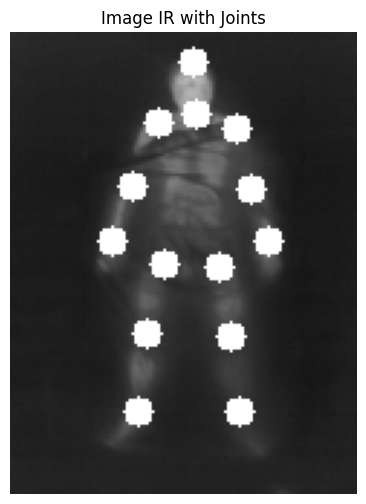

In [6]:
frame_id = 0
num_joints = joints_gt_IR.shape[1]

for j in range(num_joints):
    x = int(joints_gt_IR[0, j, frame_id])
    y = int(joints_gt_IR[1, j, frame_id])

    cv2.circle(image_ir_color, (x, y), 5, (255, 255, 255), -1)

image_for_show = cv2.cvtColor(image_ir_color, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_for_show)
plt.title("Image IR with Joints")
plt.axis('off')
plt.show()

In [7]:
def load_patient_data(patient_id, base_path="/mnt/DADES2/SLP/SLP/danaLab"):
    """
    For a given patient (e.g., '00001'), the function loads:
      - The joints .mat file (using the variable "joints_gt").
      - The paths of the images in each subfolder within IR (cover1, cover2, uncover).
    """
    # Patient folder path
    patient_dir = os.path.join(base_path, patient_id)
    
    # Path to the .mat file with joints
    joints_mat_path = os.path.join(patient_dir, "joints_gt_IR.mat")
    datos = sio.loadmat(joints_mat_path)
    joints_gt_IR = datos["joints_gt"]
    
    #Folder where the IR images are stored
    ir_folder = os.path.join(patient_dir, "IR")
    # Subfolders to look for images
    # (cover1, cover2, uncover)
    subfolders = ["cover1", "cover2", "uncover"]
    images = {folder: [] for folder in subfolders}
    
    for folder in subfolders:
        folder_path = os.path.join(ir_folder, folder)
        # Obtain the list of image files in the folder ordered alphabetically
        img_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        for img_file in img_files:
            images[folder].append(os.path.join(folder_path, img_file))
    
    return joints_gt_IR, images

Paciente 00001 tiene 45 frames y 14 joints.


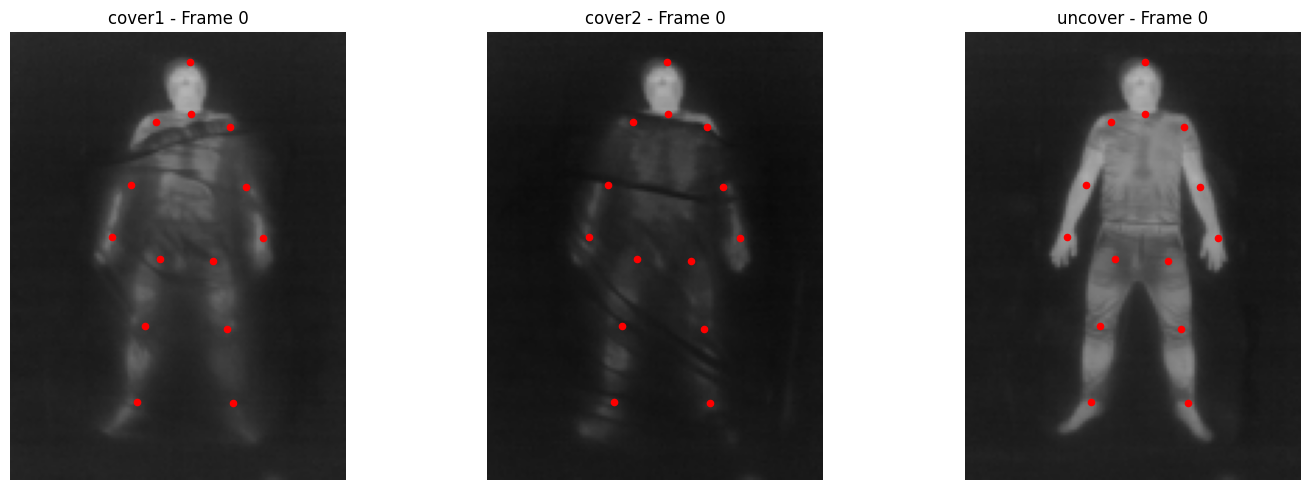

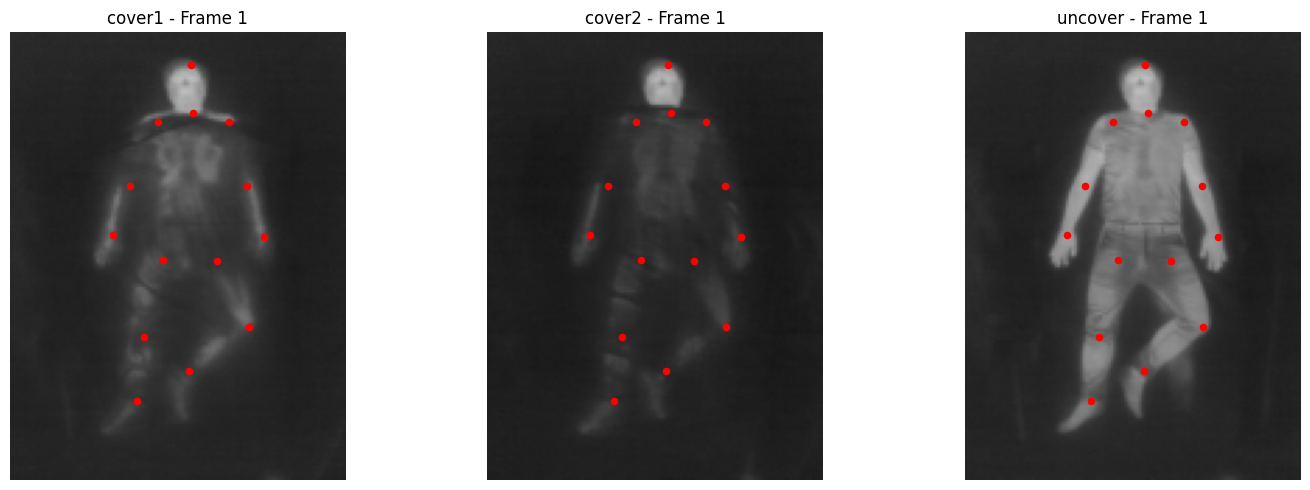

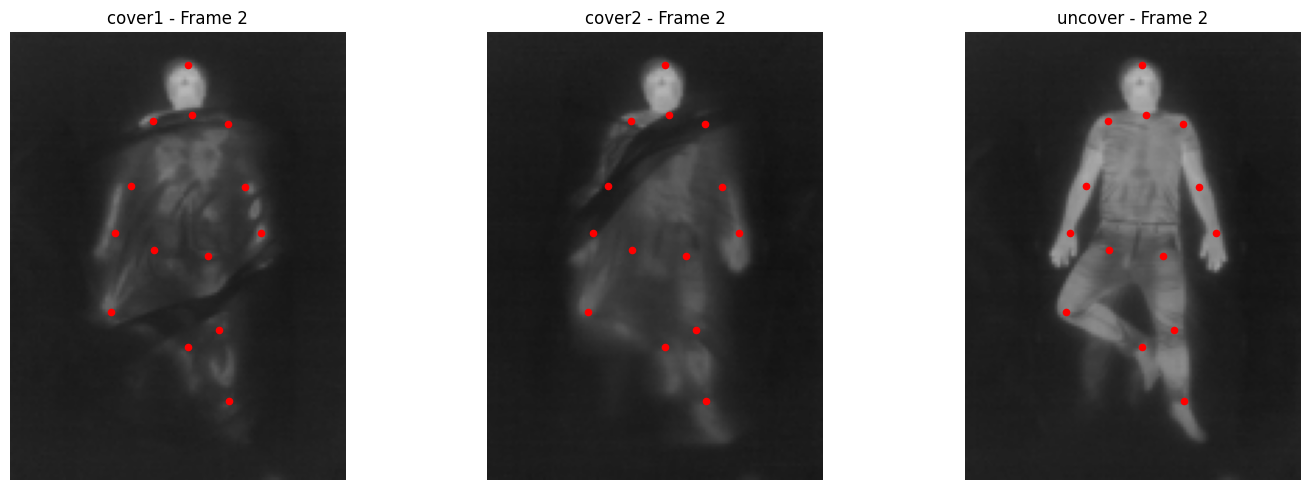

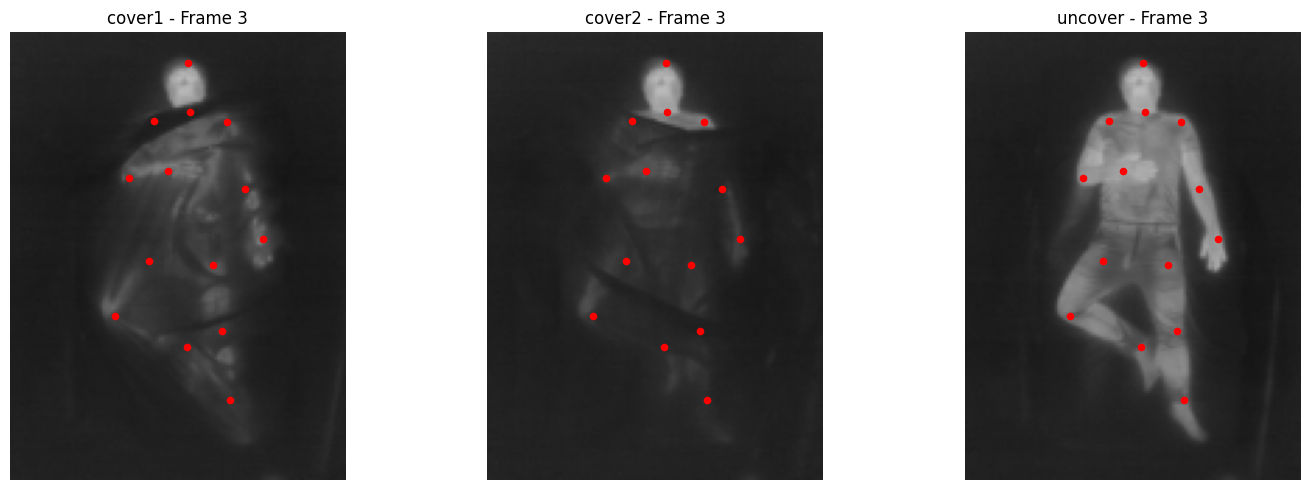

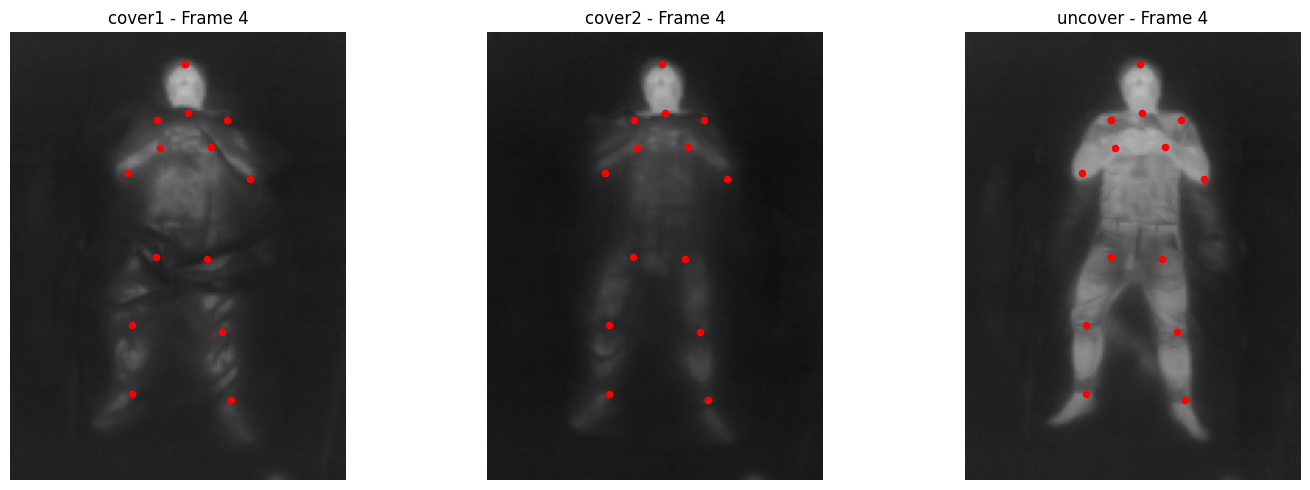

In [8]:
# Example for the patient with ID "00001"
patient_id = "00001"
# Load the data
joints_gt_IR, images = load_patient_data(patient_id)

# I assume that joints_gt_IR is a 3D array with shape (3, num_joints, num_frames)
num_frames = joints_gt_IR.shape[2]
num_joints = joints_gt_IR.shape[1]
print(f"Paciente {patient_id} tiene {num_frames} frames y {num_joints} joints.")

# Show the first 5 frames of each subfolder (cover1, cover2, uncover)
for frame_index in range(min(5, num_frames)):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # for each subfolder (cover1, cover2, uncover)
    for i, folder in enumerate(["cover1", "cover2", "uncover"]):
        if frame_index < len(images[folder]):
            img_path = images[folder][frame_index]
            # Cargar la imagen en escala de grises
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print("Error al cargar imagen:", img_path)
                continue
            # Convert the image to RGB for displaying with matplotlib
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            # Extract the joints for the current frame
            xs = joints_gt_IR[0, :, frame_index]
            ys = joints_gt_IR[1, :, frame_index]
            
            # Show the image with joints
            axs[i].imshow(img_color)
            axs[i].scatter(xs, ys, s=20, c='red')  # Ajusta 's' para modificar el tamaño de los puntos si lo deseas
            axs[i].set_title(f"{folder} - Frame {frame_index}")
            axs[i].axis('off')
        
        else:
            print(f"No hay suficiente imágenes en la subcarpeta {folder} para el frame {frame_index}")
    
    plt.tight_layout()
    plt.show()

### PRE-PROCESS:

First of all, let's load the PoseEstimationWithMobileNet model, since it will be the one we use for our first part.

In [9]:
if REPO_PATH not in sys.path:
    sys.path.insert(0, REPO_PATH)
from models.with_mobilenet import PoseEstimationWithMobileNet

This code  iterates through patient folders containing infrared (IR) images, converts them from grayscale to “pseudo‑RGB” by replicating the single channel three times, and saves the result in a parallel output directory structure. We only run this once to create the new RGB image dataset for use in the Pose model.

In [ ]:
"""
output_base = "/mnt/DADES/home/lchachoud/outputs/danaLab_rgb"
if not os.path.exists(output_base):
    os.makedirs(output_base)

# Base path where the patient folders are located
base_path = "/mnt/DADES/home/lchachoud/danaLab"  
paciente_list = sorted(os.listdir(base_path))
paciente_list = [p for p in paciente_list if p.isdigit() and os.path.isdir(os.path.join(base_path, p))]

for paciente_id in paciente_list:
    paciente_dir = os.path.join(base_path, paciente_id)
    ir_dir = os.path.join(paciente_dir, "IR")
    
    if not os.path.isdir(ir_dir):
        print(f"La carpeta IR no existe en el paciente {paciente_id}")
        continue

    subfolders = ["cover1", "cover2", "uncover"]
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(ir_dir, subfolder)
        if not os.path.isdir(subfolder_path):
            print(f"La subcarpeta {subfolder} no existe en {ir_dir}")
            continue

        # Define the output subfolder for RGB images
        # Create the output subfolder if it doesn't exist
        out_subfolder = os.path.join(output_base, paciente_id, "IR", subfolder + "_rgb")
        os.makedirs(out_subfolder, exist_ok=True)

        img_files = sorted([f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        for img_file in img_files:
            img_path = os.path.join(subfolder_path, img_file)
            img_ir = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_ir is None:
                print(f"Error al cargar la imagen: {img_path}")
                continue

            img_pseudorgb = cv2.merge([img_ir, img_ir, img_ir])
            out_path = os.path.join(out_subfolder, img_file)
            cv2.imwrite(out_path, img_pseudorgb)
            print(f"Paciente {paciente_id} - {subfolder}: Guardado {out_path}")

print("Procesamiento completado.")
"""


The load_joint_labels_from_original function opens the MATLAB file containing joint labels in the format (3, J, F), extracts only the X and Y coordinates for each joint, and arranges them into an array of shape (F, J, 2) to facilitate subsequent use in Python.

In [10]:
def load_joint_labels_from_original(patient_dir):
    data = sio.loadmat(os.path.join(patient_dir, "joints_gt_IR.mat"))
    joints = data["joints_gt"]  # (3, J, F)
    F, J = joints.shape[2], joints.shape[1]
    out = np.zeros((F, J, 2), dtype=np.float32)
    for f in range(F):
        out[f,:,0] = joints[0,:,f]
        out[f,:,1] = joints[1,:,f]
    return out  # (frames, joints, 2)

The IRPoseDataset class constructs a dataset by pairing each patient's IR pseudo‑RGB images with their corresponding joint coordinates and ground-truth pressure maps. For each sample, it loads the grayscale IR image, converts it to pseudo‑RGB, resizes and normalizes it, and scales the joint coordinates to match the new resolution. Additionally, it loads and processes the corresponding pressure map for the same frame. Each sample returned includes the processed image tensor, the scaled joint coordinates, the pressure map tensor, and the patient index, making the dataset suitable for multi-task learning involving both pose estimation and pressure map prediction.

In [11]:
class IRPoseDataset(Dataset):
    def __init__(self, base_path, patient_list, subfolders, frame_indices, joint_labels):
        self.samples = []
        for pid in patient_list:
            for sub in subfolders:
                img_dir = os.path.join(base_path, pid, "IR", sub)
                pm_dir  = os.path.join(ORIG_ROOT, pid, "PM", sub.replace("_rgb", ""))  # presión

                if not os.path.isdir(img_dir) or not os.path.isdir(pm_dir): 
                    continue

                files = sorted(f for f in os.listdir(img_dir) if f.lower().endswith((".png", "jpg", "jpeg")))
                pm_files = sorted(f for f in os.listdir(pm_dir) if f.lower().endswith(".png"))

                for idx in frame_indices:
                    if idx < len(files) and idx < len(pm_files):
                        img_path = os.path.join(img_dir, files[idx])
                        pm_path = os.path.join(pm_dir, pm_files[idx])
                        sub_idx = int(pid)  # ← importante: convertir a entero
                        self.samples.append((img_path, joint_labels[pid][idx], pm_path, sub_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        img_path, lbl, pm_path, sub_idx = self.samples[i]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        h0, w0 = img.shape
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (256, 256)).astype(np.float32) / 255.0

        sx, sy = 256.0 / w0, 256.0 / h0
        lbl_scaled = lbl.copy()
        lbl_scaled[:, 0] *= sx
        lbl_scaled[:, 1] *= sy

        pm_img = cv2.imread(pm_path, cv2.IMREAD_GRAYSCALE)
        pm_img = cv2.resize(pm_img, (256, 256)).astype(np.float32) / 255.0
        pressure_map = np.expand_dims(pm_img, axis=0)  # [1, 256, 256]

        return (
            torch.tensor(img.transpose(2, 0, 1)),  # [3, 256, 256]
            torch.tensor(lbl_scaled).float(),     # [J, 2]
            torch.tensor(pressure_map).float(),   # [1, 256, 256]
            sub_idx                                # int
        )

This function converts a batch of 2D joint coordinates into Gaussian heatmaps suitable for training convolutional pose estimation models such as OpenPose-based architectures. Since the model outputs heatmaps of shape (B, J, H, W), one channel per joint—this transformation allows us to create ground truth labels in the same format.
Each joint coordinate (originally defined on a 256×256 grid) is rescaled to the model’s output resolution (H, W) and used as the center of a 2D Gaussian. The result is a soft spatial distribution where pixel intensity indicates the likelihood of a joint being at that location.

Using this function is essential because pose estimation networks are trained to predict heatmaps, not direct coordinate values. By providing Gaussian heatmaps as targets, we enable the model to learn spatial uncertainty and localization, making the training process more robust to annotation noise and improving the model’s ability to generalize to unseen data. This approach also allows the network to leverage convolutional operations for spatial reasoning, which is fundamental for accurate joint localization in images.

- I have created `joints_to_heatmaps` for use it inside the PyTorch training/validation loops for efficient, batched, GPU-based heatmap generation.
- I have created `joints_to_heatmaps_numpy` for quick, single-sample heatmap creation in CPU-based scripts, e.g., for plotting or offline data preparation.

In [12]:
def joints_to_heatmaps(joints, H, W, sigma=2.0):
    """
    Convert joint coordinates to heatmaps.
    Args:
        joints (torch.Tensor): Tensor of shape (B, J, 2) with joint coordinates.
        H (int): Height of the output heatmaps.
        W (int): Width of the output heatmaps.
        sigma (float, optional): Standard deviation for the Gaussian kernel. Default is 2.0.
    Returns:
        torch.Tensor: Heatmaps of shape (B, J, H, W).
    """
    B, J, _ = joints.shape
    dev = joints.device
    hm = torch.zeros(B, J, H, W, device=dev)
    sx, sy = W/256.0, H/256.0
    yy, xx = torch.meshgrid(
        torch.arange(H, device=dev).float(),
        torch.arange(W, device=dev).float(),
        indexing="ij"
    )
    for b in range(B):
        for j in range(J):
            x = (joints[b,j,0] / 256.0) * W
            y = (joints[b,j,1] / 256.0) * H
            hm[b,j] = torch.exp(-((xx-x)**2 + (yy-y)**2)/(2*sigma*sigma))
    return hm

In [13]:
def joints_to_heatmaps_numpy(joints, H, W, sigma=2.0):
    """
    Convert joint coordinates to heatmaps using numpy.
    args:
        joints: (J, 2) array with joint coordinates
        H, W: height and width of the output heatmaps
        sigma: standard deviation for the Gaussian kernel   
    returns:
        heatmaps: (J, H, W) array with heatmaps

    """
    J = joints.shape[0] # number of joints
    heatmaps = np.zeros((J, H, W), dtype=np.float32)
    for j, (x, y) in enumerate(joints):
        if x < 0 or y < 0:
            continue
        xx, yy = np.meshgrid(np.arange(W), np.arange(H))
        heatmaps[j] = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
    return heatmaps

For each patient, the code begins by loading their original joint annotations and then iterates through the three RGB subfolders (cover1_rgb, cover2_rgb, and uncover_rgb), extracting the paths for the first 45 frames. Each image is then paired with its corresponding scaled joint coordinates, and all samples are aggregated into a single dataset. Once this gathering is complete for all patients, the dataset is split into three parts: 70% for training, 20% for testing, and 10% for validation. Three DataLoaders are then created with a batch size of 8, shuffling enabled for the training set and disabled for validation and test sets, to support the pose estimation training and evaluation process.

In [14]:
base_path = "/mnt/DADES/home/lchachoud/outputs/danaLab_rgb"
patient_list = sorted(d for d in os.listdir(base_path) if d.isdigit())

joint_labels = {
    pid: load_joint_labels_from_original(os.path.join("/mnt/DADES2/SLP/SLP/danaLab", pid))
    for pid in patient_list
}

subfolders = ["cover1_rgb", "cover2_rgb", "uncover_rgb"]
frame_indices = range(45)

# Create the complete dataset
dataset = IRPoseDataset(base_path, patient_list, subfolders, frame_indices, joint_labels)

# Split into 70% train, 20% test, 10% validation
total_size = len(dataset)
n_train = int(0.7 * total_size)
n_test = int(0.2 * total_size)
n_val = total_size - n_train - n_test 

train_ds, test_ds, val_ds = random_split(dataset, [n_train, n_test, n_val])

# Create the data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=4)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4)

In [15]:
import os
ir_check_path = "/mnt/DADES/home/lchachoud/outputs/danaLab_rgb/00001/IR"
print("Contenido real de IR/:", os.listdir(ir_check_path))

Contenido real de IR/: ['cover2_rgb', 'uncover_rgb', 'cover1_rgb']


### POSE_MODEL:

Initialize and Adapt the model:

In [16]:
def load_pose_model(num_joints=14, device="cuda"):
    """
    Creates an instance of PoseEstimationWithMobileNet modified to predict `num_joints` heatmaps.
    Adjusts the output layers of the model accordingly.

    Args:
        num_joints (int): Number of joints (heatmaps) to predict.
        device (str): Device to load the model on ("cuda" or "cpu").

    Returns:
        PoseEstimationWithMobileNet: The adapted pose estimation model.
    """
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = PoseEstimationWithMobileNet()

    # Partially freeze the backbone
    for name, param in model.model.named_parameters():
        if name.startswith("0.") or name.startswith("1.") or name.startswith("2."):
            param.requires_grad = False
        else:
            param.requires_grad = True

    # Optionally unfreeze CPM
    for name, param in model.cpm.named_parameters():
        param.requires_grad = True

    # Adjust initial_stage output to produce `num_joints` heatmaps
    in_ch_init = model.initial_stage.heatmaps[1][0].in_channels
    model.initial_stage.heatmaps[1][0] = nn.Conv2d(in_ch_init, num_joints, kernel_size=1)

    # Calculate input channels for the trunk of refinement_stages
    back_ch = model.cpm.conv[0].out_channels
    paf_ch = model.initial_stage.pafs[1][0].out_channels
    new_in = back_ch + num_joints + paf_ch

    # Replace layers in each refinement_stage
    for stage in model.refinement_stages:
        out_ch = stage.trunk[0].initial[0].out_channels
        stage.trunk[0].initial[0] = nn.Conv2d(new_in, out_ch, kernel_size=1)

        in_hm = stage.heatmaps[1][0].in_channels
        stage.heatmaps[1][0] = nn.Conv2d(in_hm, num_joints, kernel_size=1)

    model.to(device)
    return model

In [17]:
model_pose = load_pose_model(num_joints=14, device="cuda")
# Define the optimizer and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_pose.parameters()), lr=1e-4)
criterion = nn.MSELoss()

In [ ]:
#for name, param in model_pose.model.named_parameters():
    #print(name, param.shape)

With this script, I compute the average position of each joint across all patients and frames, which allows me to visualize how the joints are spatially distributed within the image. This information is essential for properly designing the skeleton structure and correctly adjusting the joint connections and their corresponding weights before training the pose estimation model.

In [18]:
def plot_multiple_joints(base_path, patient_id, frame_indices, titles=None, condition="uncover"):
    """
    Plots multiple frames of a patient's infrared images with overlaid joint annotations.

    Args:
        base_path (str): Base directory containing patient data.
        patient_id (str): Identifier for the patient (e.g., '00001').
        frame_indices (list of int): List of frame indices to visualize.
        titles (list of str, optional): Titles for each frame. Defaults to None.
        condition (str, optional): Subfolder name for the IR condition (e.g., 'uncover'). Defaults to "uncover".
    """
    # Load joints
    mat_path = os.path.join(base_path, patient_id, "joints_gt_IR.mat")
    data = sio.loadmat(mat_path)
    joints = data["joints_gt"]  # (3, J, F)

    # Load IR images
    ir_folder = os.path.join(base_path, patient_id, "IR", condition)
    ir_files = sorted(os.listdir(ir_folder))

    n = len(frame_indices)
    cols = 3 if n > 2 else 2
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 6))
    axs = axs.flatten()

    for i, frame_idx in enumerate(frame_indices):
        # Load image
        img_path = os.path.join(ir_folder, ir_files[frame_idx])
        img = imageio.imread(img_path)

        # XY coordinates
        joints_xy = joints[:2, :, frame_idx].T  # (J, 2)

        ax = axs[i]
        ax.imshow(img, cmap='gray')
        for idx, (x, y) in enumerate(joints_xy):
            ax.scatter(x, y, c='red')
            ax.text(x+3, y, f"{idx}", color='yellow', fontsize=8)
        
        title = titles[i] if titles and i < len(titles) else f"Frame {frame_idx}"
        ax.set_title(title)
        ax.axis('off')

    # Hide extra axes if there are gaps
    for j in range(len(frame_indices), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

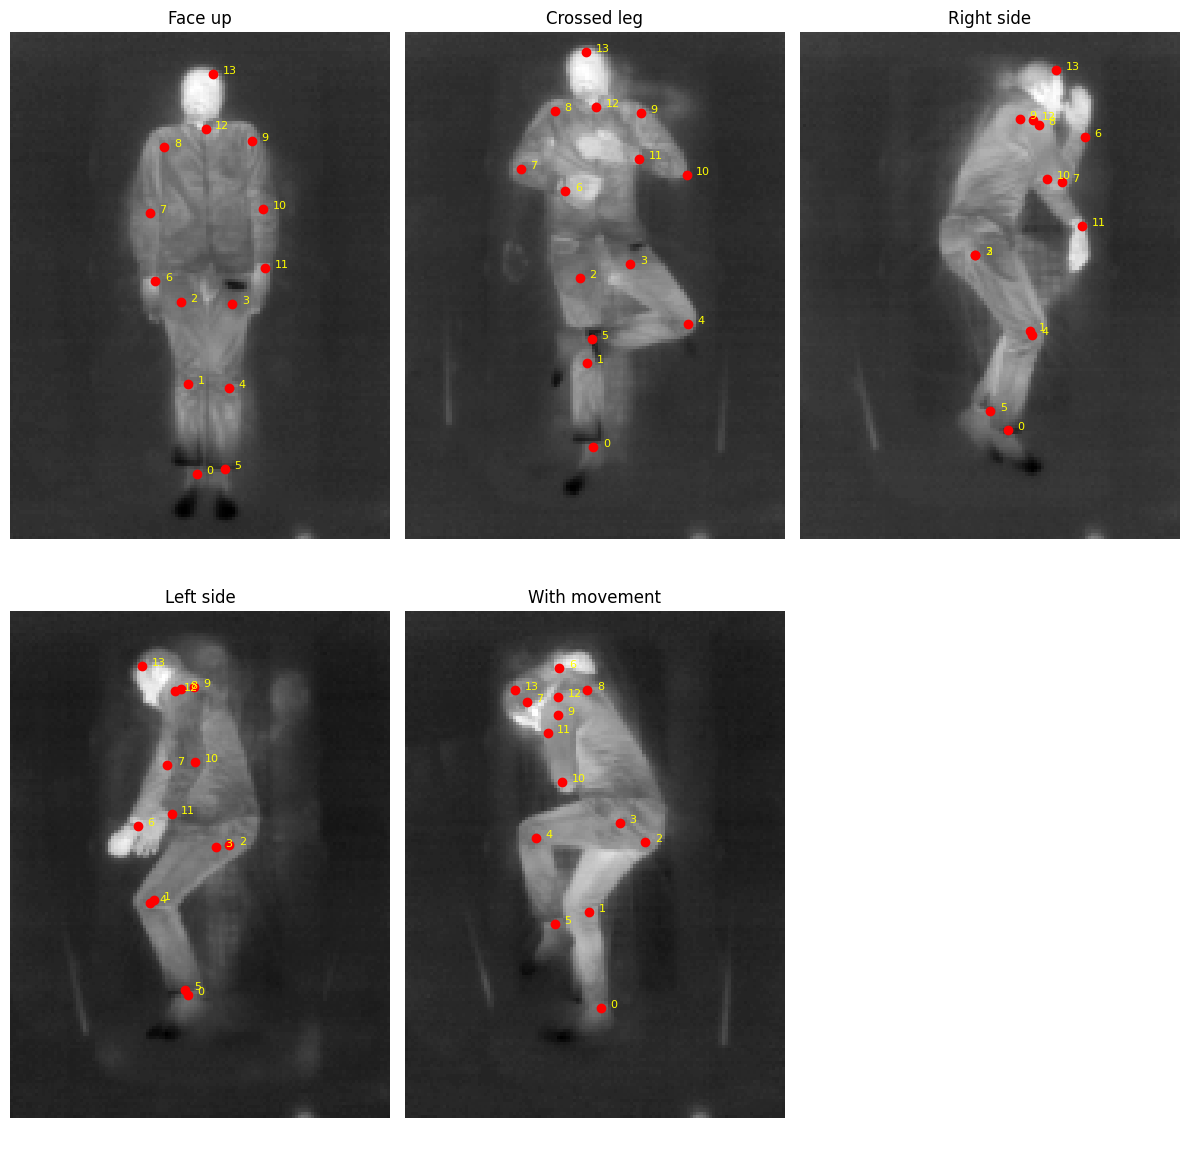

In [19]:
#Visualize the joints for a specific patient and condition
base = "/mnt/DADES2/SLP/SLP/danaLab"
plot_multiple_joints(
    base_path=base,
    patient_id="00007",
    frame_indices=[0, 10, 20, 30, 40],
    titles=["Face up", "Crossed leg", "Right side", "Left side", "With movement"],
    condition="uncover"
)

I verified that even as the patient moves and changes posture, the joint-points in the ground truth maintain a consistent numbering. For instance, JP0 always refers to the same foot (the right one), and the same applies to all other joints. No inversion or inconsistency related to body orientation is observed. Therefore, it does not seem necessary to apply any additional normalization or transformation to correct for orientation changes.

In [22]:
# SKELETON structured by torso, limbs, and head

SKELETON = [
    # Torso (closed figure): hips and shoulders
    (2, 3),   # right hip ↔ left hip
    (3, 9),   # left hip ↔ left shoulder
    (9, 8),   # left shoulder ↔ right shoulder
    (8, 2),   # right shoulder ↔ right hip

    # Neck connection with shoulders and head
    (9, 12), (8, 12),   # neck ↔ shoulders
    (12, 13),           # neck ↔ head

    # Arms (from shoulders)
    (8, 6), (6, 7),     # right shoulder → elbow → wrist
    (9, 11), (11, 10),  # left shoulder → elbow → wrist

    # Legs (from hips)
    (2, 1), (1, 0),     # right hip → knee → heel
    (3, 4), (4, 5),     # left hip → knee → heel
]

The save_pose_predictions function runs the pose estimation model on a given DataLoader (train, val, or test set), saves the predicted skeleton heatmaps and ground-truth pressure maps for each sample, and stores them in a structured directory. For each batch, it:

- Sets the model to evaluation mode and disables gradient computation.
- For each image in the batch, extracts the predicted skeleton heatmaps and the corresponding ground-truth pressure map.
- Saves both as .npy files in a new folder for each sample, along with a text file containing the patient ID.
- Organizes the output by split and provides a unique folder for each prediction.

This function is used to generate datasets of predicted skeletons and their corresponding pressure maps for further analysis or for training the next stage of the pipeline.

In [21]:
def save_pose_predictions(model, dataloader, split_name, base_output="/mnt/DADES/home/lchachoud/skeleton_pressure_dataset_pred_FINAL"):
    """
    Runs the pose estimation model on a given DataLoader and saves the predicted skeleton heatmaps 
    and ground-truth pressure maps for each sample in a structured directory.

    Args:
        model (torch.nn.Module): Trained pose estimation model.
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of images and pressure maps.
        split_name (str): Name of the dataset split ("train", "val", or "test") for output folder naming.
        base_output (str, optional): Base directory to save the predictions. Defaults to the specified path.

    Saves:
        For each sample in the dataloader, creates a folder named '{split_name}_Fxxxx' containing:
            - 'skeleton.npy': Predicted skeleton heatmaps (numpy array, shape [J, H, W]).
            - 'pressure_map.npy': Ground-truth pressure map (numpy array, shape [1, H, W]).
            - 'id.txt': Patient ID as a text file.
    """
    model.eval()
    os.makedirs(base_output, exist_ok=True)
    device = next(model.parameters()).device
    idx_counter = 0

    with torch.no_grad():
        for imgs, _, pressure_maps, sub_idxs in tqdm(dataloader, desc=f"Saving {split_name} predictions"):
            imgs = imgs.to(device)
            hmaps = model(imgs)
            hmaps = hmaps[-2] if isinstance(hmaps, list) else hmaps  # [B, J, H, W]

            for b in range(imgs.size(0)):
                skeleton = hmaps[b].cpu().numpy()              # [J, H, W]
                pressure_map = pressure_maps[b].cpu().numpy()  # [1, H, W]
                sub_idx = sub_idxs[b]

                save_folder = os.path.join(base_output, f"{split_name}_F{idx_counter:04d}")
                os.makedirs(save_folder, exist_ok=True)

                np.save(os.path.join(save_folder, "skeleton.npy"), skeleton)
                np.save(os.path.join(save_folder, "pressure_map.npy"), pressure_map)

                # Guardar el ID del paciente
                with open(os.path.join(save_folder, "id.txt"), "w") as f:
                    f.write(str(sub_idx))

                idx_counter += 1

    print(f"{split_name} predictions saved in: {base_output}")

#### Training and evalution of the model:

In [22]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define where to save the model and metrics
save_dir = "/mnt/DADES/home/lchachoud/pose_model"
os.makedirs(save_dir, exist_ok=True)  
save_path = os.path.join(save_dir, "best_pose_model.pth")

train_losses, val_losses, test_losses = [], [], []
max_epochs = 50 #After 50 epochs, the model was not improving a lot
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(1, max_epochs + 1):

    # Training
    model_pose.train()
    run_tr = 0.0
    for imgs, joints, _, _ in train_loader:
        imgs, joints = imgs.to(device), joints.to(device)
        out = model_pose(imgs)
        hmaps = out[-2] if isinstance(out, list) else out
        B, J, Hp, Wp = hmaps.shape
        target = joints_to_heatmaps(joints, Hp, Wp)
        loss = criterion(hmaps, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        run_tr += loss.item() * imgs.size(0)
    epoch_train_loss = run_tr / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model_pose.eval()
    run_val = 0.0
    with torch.no_grad():
        for imgs, joints, _, _ in val_loader:
            imgs, joints = imgs.to(device), joints.to(device)
            out = model_pose(imgs)
            hmaps = out[-2] if isinstance(out, list) else out
            target = joints_to_heatmaps(joints, Hp, Wp)
            loss = criterion(hmaps, target)
            run_val += loss.item() * imgs.size(0)
    epoch_val_loss = run_val / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Test
    model_pose.eval()
    run_test = 0.0
    with torch.no_grad():
        for imgs, joints, _, _ in test_loader:
            imgs, joints = imgs.to(device), joints.to(device)
            out = model_pose(imgs)
            hmaps = out[-2] if isinstance(out, list) else out
            target = joints_to_heatmaps(joints, Hp, Wp)
            loss = criterion(hmaps, target)
            run_test += loss.item() * imgs.size(0)
    epoch_test_loss = run_test / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch}/{max_epochs} — "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f}")

    # Early stopping and model saving
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        early_stop_counter = 0
        torch.save(model_pose.state_dict(), save_path)
        print(f"Model saved: {save_path}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

# save models and metrics
save_data = {
    "model_state": model_pose.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
    "test_losses": test_losses,
    "best_val_loss": best_val_loss
}
torch.save(save_data, os.path.join(save_dir, "pose_model_with_losses.pth"))
print("Model and metrics were saved.")

Epoch 1/50 — Train Loss: 0.0063 | Val Loss: 0.0050 | Test Loss: 0.0050
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 2/50 — Train Loss: 0.0041 | Val Loss: 0.0037 | Test Loss: 0.0037
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 3/50 — Train Loss: 0.0033 | Val Loss: 0.0033 | Test Loss: 0.0033
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 4/50 — Train Loss: 0.0028 | Val Loss: 0.0027 | Test Loss: 0.0027
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 5/50 — Train Loss: 0.0024 | Val Loss: 0.0025 | Test Loss: 0.0025
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 6/50 — Train Loss: 0.0021 | Val Loss: 0.0021 | Test Loss: 0.0022
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 7/50 — Train Loss: 0.0019 | Val Loss: 0.0021 | Test Loss: 0.0021
Model saved: /mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth
Epoch 8/50 — 

Use this code only in case that you don't want to retrain the model:

In [ ]:
"""
# Charge the pre-trained model that we have saved
model_pose.load_state_dict(torch.load("/mnt/DADES/home/lchachoud/pose_model/best_pose_model.pth"))

# save predictions
save_pose_predictions(model_pose, train_loader, "train")
save_pose_predictions(model_pose, val_loader, "val")
save_pose_predictions(model_pose, test_loader, "test")
"""

### VISUALIZATION OF RESULTS POSE_MODEL:

In [26]:
def visualize_pose_predictions(data_loader, model_pose, dataset_name="val", device="cuda"):
    """
    Visualize pose predictions vs ground truth for a batch from a DataLoader.
    Args:
        data_loader (DataLoader): DataLoader providing batches of images and joints.
        model_pose (torch.nn.Module): Trained pose estimation model.
        dataset_name (str): Name of the dataset split ("val", "test", etc.) for plot titles.
        device (str): Device to run the model on ("cuda" or "cpu").
    """
    model_pose.eval()
    for batch in data_loader:
        imgs, joints, _, _ = batch
        if imgs.size(0) < 2:
            continue  # skip batches too small to display
        imgs, joints = imgs.to(device), joints.to(device)
        break  # use only the first valid batch

    with torch.no_grad():
        out = model_pose(imgs)
        hmaps = out[-2] if isinstance(out, list) else out  # [B, J, H, W]

    B, J, Hp, Wp = hmaps.shape
    preds = torch.zeros(B, J, 2, device=device)

    for b in range(B):
        for j in range(J):
            flat = hmaps[b, j].argmax()
            y, x = divmod(flat.item(), Wp)
            preds[b, j] = torch.tensor([x * 256.0 / Wp, y * 256.0 / Hp], device=device)

    # Visualization
    for i in range(B):
        img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        gt = joints[i].cpu().numpy()
        pr = preds[i].cpu().numpy()

        plt.figure(figsize=(4, 4))
        plt.imshow(img, vmin=0, vmax=1)
        plt.scatter(gt[:, 0], gt[:, 1], c='cyan', s=30, label='GT')
        plt.scatter(pr[:, 0], pr[:, 1], c='magenta', s=30, marker='x', label='Pred')

        for (u, v) in SKELETON:
            plt.plot([gt[u, 0], gt[v, 0]], [gt[u, 1], gt[v, 1]], c='cyan', linewidth=2)
            plt.plot([pr[u, 0], pr[v, 0]], [pr[u, 1], pr[v, 1]], c='magenta', linestyle='--', linewidth=2)

        plt.legend(loc='upper right')
        plt.axis('off')
        plt.title(f"{dataset_name.upper()} — Prediction vs GT (sample {i})")
        plt.tight_layout()
        plt.show()

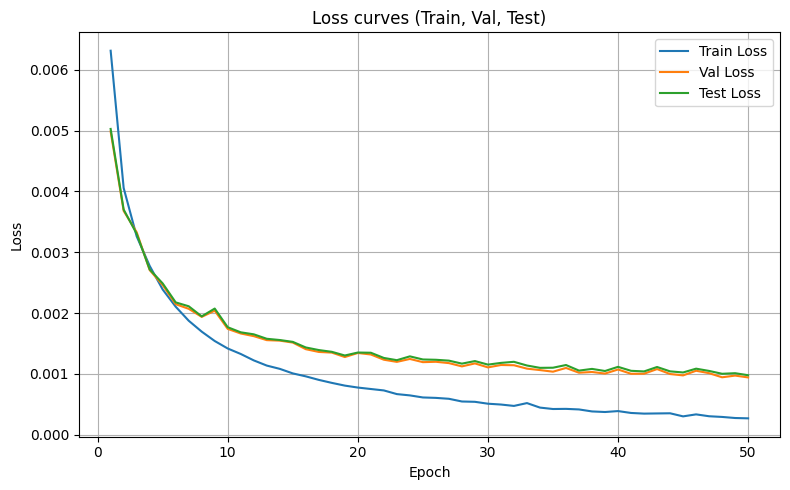

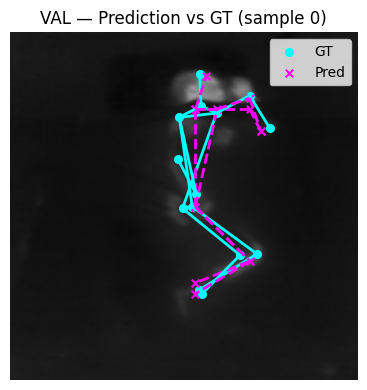

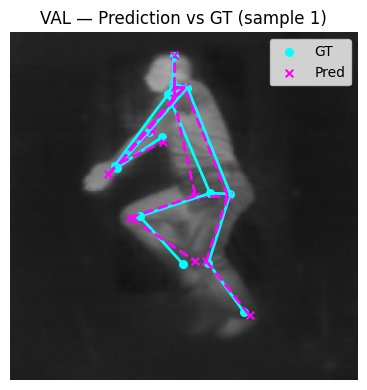

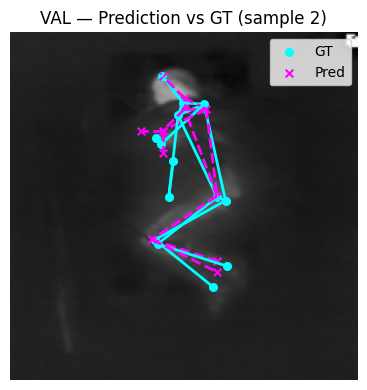

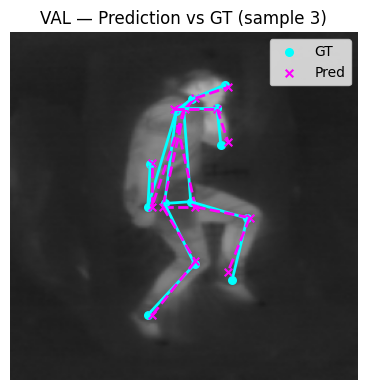

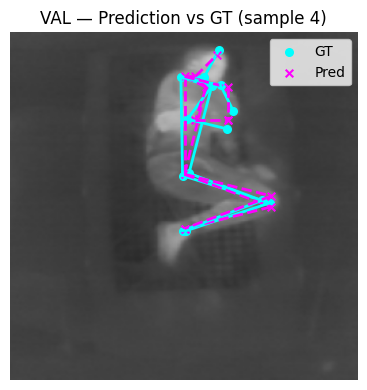

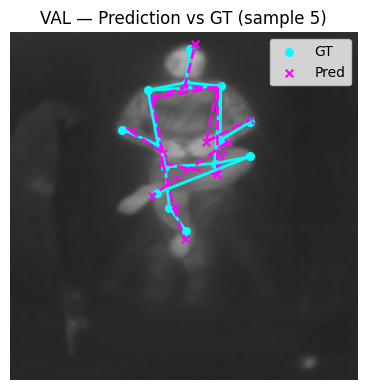

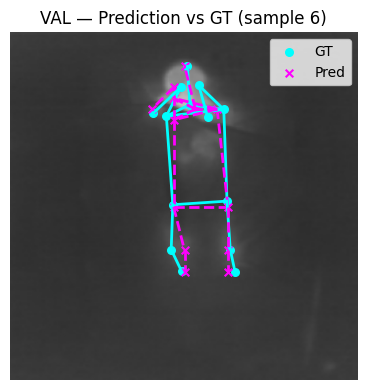

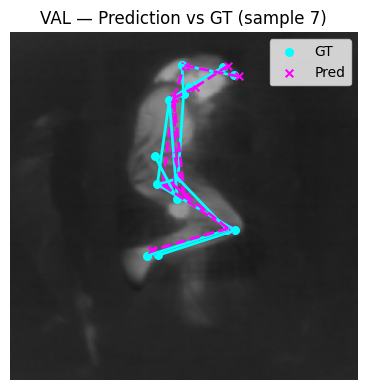

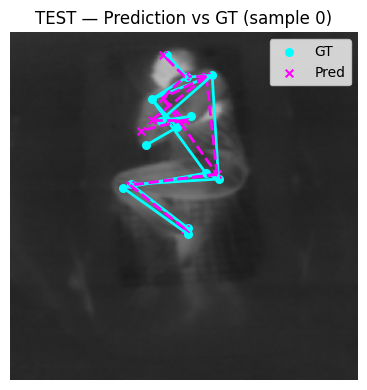

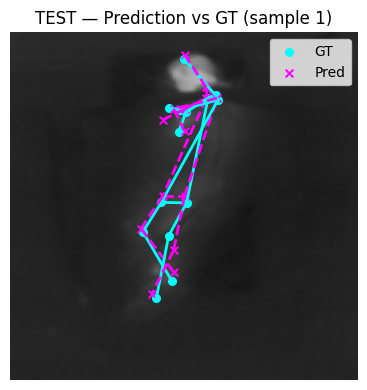

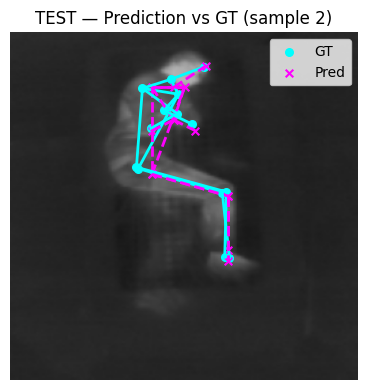

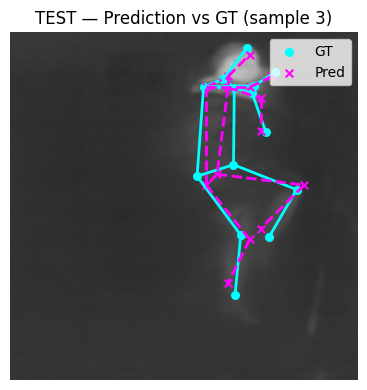

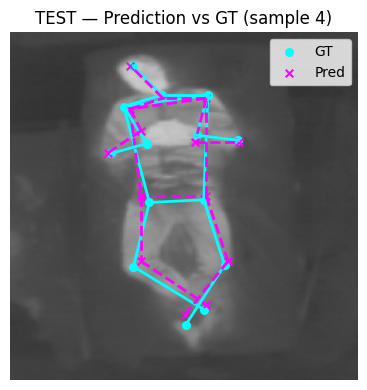

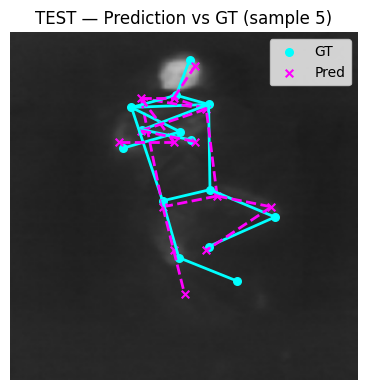

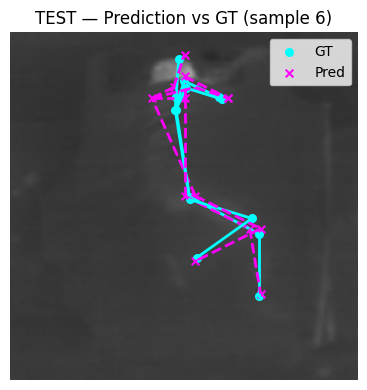

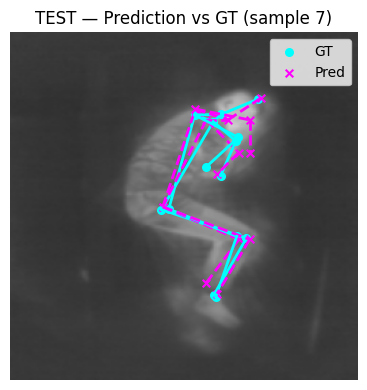

In [27]:
# Plot curves of loss function
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss")
plt.plot(range(1, len(test_losses)+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curves (Train, Val, Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization of predictions 
visualize_pose_predictions(val_loader, model_pose, dataset_name="val", device=device)
visualize_pose_predictions(test_loader, model_pose, dataset_name="test", device=device)

#### Compute the metrics:

In this section, I compute the evaluation metrics for the pose estimation model. These metrics allow me to objectively quantify the model's performance on the test and validation sets, beyond simple visual inspection.

The mean Euclidean distance between predictions and actual joint positions (Mean Euclidean Distance), the percentage of correctly localized joints within a threshold (PCK), and the normalized mean error (Normalized Mean Error) are calculated. These metrics are essential for detecting possible systematic errors and validating that the model generalizes correctly to unseen data. Additionally, they help determine whether the model is accurate enough for clinical applications or if further improvements are needed.

In [28]:
def extract_coords_from_heatmaps(hmaps):
    """
    Extracts (x, y) coordinates from each heatmap.
    Args:
        hmaps (torch.Tensor): Heatmaps of shape (B, J, H, W)
    Returns:
        coords (torch.Tensor): Coordinates of shape (B, J, 2) in [x, y] format, scaled to 256x256.
    """
    B, J, H, W = hmaps.shape
    coords = torch.zeros(B, J, 2, device=hmaps.device)
    for b in range(B):
        for j in range(J):
            idx = hmaps[b, j].view(-1).argmax()
            y, x = divmod(idx.item(), W)
            coords[b, j] = torch.tensor([x * 256.0 / W, y * 256.0 / H], device=hmaps.device)
    return coords

In [29]:
def compute_pose_metrics(preds, gts, threshold=5.0, normalization="image"):
    """
    preds, gts: (B, J, 2) en coordenadas absolutas
    """
    dists = torch.norm(preds - gts, dim=2)  # (B, J)
    med = dists.mean().item()
    pck = (dists < threshold).float().mean().item()

    if normalization == "image":
        norm_factor = 256.0
    elif normalization == "shoulder":
        norm_factor = torch.norm(gts[:,10] - gts[:,13], dim=1).mean().item()
    else:
        norm_factor = 1.0

    nme = med / norm_factor
    return {
        "Mean Euclidean Distance": med,
        f"PCK{threshold}px": pck,
        "Normalized Mean Error": nme
    }

In [30]:
# Metrics for test and validation sets
for loader, split in [(test_loader, "Test"), (val_loader, "Validation")]:
    all_preds, all_gts = [], []
    with torch.no_grad():
        for imgs, joints, _, _ in loader:
            imgs, joints = imgs.to(device), joints.to(device)
            out = model_pose(imgs)
            hmaps = out[-2] if isinstance(out, list) else out
            preds = extract_coords_from_heatmaps(hmaps)
            all_preds.append(preds.cpu())
            all_gts.append(joints.cpu())
    all_preds = torch.cat(all_preds, dim=0)
    all_gts = torch.cat(all_gts, dim=0)
    metrics = compute_pose_metrics(all_preds, all_gts, threshold=5.0)
    print(f"\nPose Metrics ({split} set):")
    for name, val in metrics.items():
        print(f"{name}: {val:.4f}")


Pose Metrics (Test set):
Mean Euclidean Distance: 6.0899
PCK5.0px: 0.5412
Normalized Mean Error: 0.0238

Pose Metrics (Validation set):
Mean Euclidean Distance: 5.9310
PCK5.0px: 0.5495
Normalized Mean Error: 0.0232


The results show that the model performs consistently on both the validation and test sets. The mean Euclidean distance was 5.99 pixels for validation and 6.02 pixels for test, while the normalized mean error was practically the same in both cases (0.0234 and 0.0235). Additionally, the percentage of joints correctly predicted within a radius of 5 pixels (PCK@5.0px) was approximately 54% for both sets. This indicates that the model is quite accurate at localizing keypoints and generalizes well, making it a good choice to use as input for the next stage of the project: pressure map prediction.

###     PART 2: FROM SKELETON TO PREASSURE MAP



In this second part of the project, the goal is to predict pressure maps using the estimated skeleton information and the physical characteristics of each patient (weight and height). After training a pose model that accurately extracts the body structure from infrared images, we now use that representation (along with weight and height data) as input for a U-Net neural network. This network learns to infer how pressure is distributed on the bed, helping to identify areas where pressure ulcers may develop.

### PRE-PROCESS:

First of all, I create a dictionary called "physique_dict" that associates each patient identifier with a list containing their weight and height. I build this dictionary from a CSV file that stores the physical data of each patient. Having this dictionary is necessary because, during the training of the network that predicts the pressure maps, it will be essential to quickly access each patient's weight and height in order to incorporate them as input variables along with the skeletal information.

In [2]:
# Charge the CSV file with physique data
csv_path = "/mnt/DADES2/SLP/SLP/danaLab/physiqueData.csv"  
df = pd.read_csv(csv_path)

# Create a dictionary: sub_idx → [peso, altura]
physique_dict = {
    int(row["sub_idx"]): [row["weight (kg)"], row["height (cm)"]]
    for _, row in df.iterrows()
}

# Example of how to access the physique data
print(physique_dict[1]) 

[80.0, 173.0]


Below, I create the custom_collate function to correctly batch samples from the `SkeletonPressureWithPhysiqueDataset`, which returns a tuple (skeleton, physique, pressure, sub_idx) per sample. This custom function ensures that the physique tensors (weight and height) are stacked into a [B, 2] shape for each batch, while the rest of the elements are grouped as usual. This is necessary because PyTorch's standard collate function sometimes does not handle batches well when mixing tensors and other types of information in the same batch.

In [3]:
def custom_collate(batch):
    """
    Custom collate function to handle the batch of data.
    Args:
        batch (list): List of tuples containing (image, joints, pressure_map, sub_idx).
    Returns:
        Tuple of tensors: (images, joints, pressure_maps, sub_ids).
    """
    # Unzip the batch
    skeletons, physiques, pressures, sub_ids = zip(*batch)
    physiques = torch.stack(physiques)  # Fuerza shape [B, 2]
    return default_collate(skeletons), physiques, default_collate(pressures), default_collate(sub_ids)

The `SkeletonPressureWithPhysiqueDataset` class is a custom PyTorch Dataset designed to load samples for training a neural network that predicts pressure maps from skeleton heatmaps and patient physique data (weight and height). Each sample consists of:

- The predicted skeleton heatmaps ("skeleton.npy"), shape [14, 256, 256]
- The ground-truth pressure map ("pressure_map.npy"), shape [1, 256, 256]
- The patient's weight and height, loaded from "physique_dict" using the patient ID in "id.txt"
- The patient ID (sub_idx)

The dataset scans a directory for folders matching a given prefix , loads the corresponding files, and returns all data as PyTorch tensors, ready for batching and training. If the skeleton heatmap is not the correct shape, it is resized to [14, 256, 256] using bilinear interpolation.

In [4]:
class SkeletonPressureWithPhysiqueDataset(Dataset):
    def __init__(self, root_dir, physique_dict, prefix="train_"):
        """
        Args:
            root_dir (str): Path to skeleton_pressure_dataset_pred
            physique_dict (dict): {sub_idx: [weight, height]}
            prefix (str): 'train_', 'val_' or 'test_'
        """
        self.root_dir = root_dir
        self.physique_dict = physique_dict
        self.samples = sorted([
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d)) and d.startswith(prefix)
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        folder = self.samples[idx]

        skeleton = np.load(os.path.join(folder, "skeleton.npy"))         # [14, H, W]
        pressure = np.load(os.path.join(folder, "pressure_map.npy"))     # [1, 256, 256]

        with open(os.path.join(folder, "id.txt")) as f:
            sub_idx = int(f.read().strip())

        weight, height = self.physique_dict[sub_idx]

        skeleton = torch.tensor(skeleton, dtype=torch.float32)
        pressure = torch.tensor(pressure, dtype=torch.float32)
        physique = torch.tensor([weight, height], dtype=torch.float32)  # [2] 

        #ensure the skeleton is in the right shape
        if skeleton.shape[1:] != (256, 256):
            skeleton = F.interpolate(skeleton.unsqueeze(0), size=(256, 256), mode="bilinear", align_corners=False).squeeze(0)

        return skeleton, physique, pressure, sub_idx 

#### DATA LOADERS:

In [5]:
train_dataset = SkeletonPressureWithPhysiqueDataset("/mnt/DADES/home/lchachoud/skeleton_pressure_dataset_pred_final", physique_dict, prefix="train_")
val_dataset = SkeletonPressureWithPhysiqueDataset("/mnt/DADES/home/lchachoud/skeleton_pressure_dataset_pred_final", physique_dict, prefix="val_")
test_dataset = SkeletonPressureWithPhysiqueDataset("/mnt/DADES/home/lchachoud/skeleton_pressure_dataset_pred_final", physique_dict, prefix="test_")

#DEFINITION OF THE DATA LOADERS
train_loader_2 = DataLoader(train_dataset, batch_size=8, shuffle=True,  collate_fn=custom_collate)
val_loader_2 = DataLoader(val_dataset,   batch_size=8, shuffle=False, collate_fn=custom_collate)
test_loader_2 = DataLoader(test_dataset,  batch_size=8, shuffle=False, collate_fn=custom_collate)

### UNET_PHYSIQUE MODEL:

The UNetWithPhysique class implements a U-Net style convolutional neural network designed to predict pressure maps from input skeleton heatmaps and patient physique data (weight and height). 

**Key features:**
- **Input:** The model takes a tensor of shape `[B, 16, 256, 256]`, where 14 channels correspond to skeleton heatmaps and 2 channels correspond to the patient's weight and height, broadcasted spatially.
- **Architecture:** 
    - **Encoder:** Four levels of double convolutional blocks with max pooling, progressively reducing spatial dimensions and increasing feature depth.
    - **Bottleneck:** A central double convolution block with the highest feature depth.
    - **Decoder:** Four levels of upsampling (transpose convolutions) and double convolutional blocks, with skip connections from the encoder to preserve spatial information.
    - **Output:** A final 1×1 convolution reduces the feature maps to a single-channel output representing the predicted pressure map.
- **Skip Connections:** Standard U-Net skip connections concatenate encoder features with decoder features at each level, helping the model retain fine-grained spatial details.
This architecture allows the model to leverage both spatial (skeleton) and global (physique) information to accurately infer pressure distributions.

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetWithPhysique(nn.Module):
    def __init__(self, in_channels=16, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.center = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        center = self.center(self.pool4(enc4))
        dec4 = self.dec4(torch.cat([self.up4(center), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))
        return self.out(dec1)

### MODEL TRAINING AND EVALUATION:

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model_Unet = UNetWithPhysique().to(device)

In [ ]:
optimizer = torch.optim.Adam(model_Unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

save_path = "/mnt/DADES/home/lchachoud/second_model_unet_with_physique_FINAL.pth"
best_val_loss = float("inf")
patience, counter = 5, 0

train_losses, val_losses, test_losses = [], [], []

for epoch in range(1, 51):
    print(f"\nEpoch {epoch}")

    #train
    model_Unet.train()
    train_loss = 0.0
    for i, (skeleton, physique, pressure, _) in enumerate(train_loader_2):
        skeleton, physique, pressure = skeleton.to(device), physique.to(device), pressure.to(device)
        B = skeleton.size(0)
        physique_exp = physique.view(B, 2, 1, 1).expand(B, 2, 256, 256)
        x_input = torch.cat([skeleton, physique_exp], dim=1)

        pred = model_Unet(x_input)
        loss = criterion(pred, pressure)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B
        print(f"[Train Batch {i+1}] Loss: {loss.item():.4f}")

    train_loss /= len(train_loader_2.dataset)
    train_losses.append(train_loss)

    # Validation
    model_Unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (skeleton, physique, pressure, _) in enumerate(val_loader_2):
            skeleton, physique, pressure = skeleton.to(device), physique.to(device), pressure.to(device)
            if physique.ndim == 3 and physique.shape[1] == 14:
                physique = physique[:, 0, :]  # fix

            B = skeleton.size(0)
            physique_exp = physique.view(B, 2, 1, 1).expand(B, 2, 256, 256)
            x_input = torch.cat([skeleton, physique_exp], dim=1)

            pred = model_Unet(x_input)
            batch_loss = criterion(pred, pressure).item()
            val_loss += batch_loss * B
            print(f"[Val Batch {i+1}] Loss: {batch_loss:.4f}")

    val_loss /= len(val_loader_2.dataset)
    val_losses.append(val_loss)

    # test
    test_loss = 0.0
    with torch.no_grad():
        for i, (skeleton, physique, pressure, _) in enumerate(test_loader_2):
            skeleton, physique, pressure = skeleton.to(device), physique.to(device), pressure.to(device)
            if physique.ndim == 3 and physique.shape[1] == 14:
                physique = physique[:, 0, :]
            B = skeleton.size(0)
            physique_exp = physique.view(B, 2, 1, 1).expand(B, 2, 256, 256)
            x_input = torch.cat([skeleton, physique_exp], dim=1)

            pred = model_Unet(x_input)
            batch_loss = criterion(pred, pressure).item()
            test_loss += batch_loss * B
            print(f"[Test Batch {i+1}] Loss: {batch_loss:.4f}")

    test_loss /= len(test_loader_2.dataset)
    test_losses.append(test_loss)

    # Summary
    print(f"\nEpoch {epoch} Summary — Train: {train_loss:.4f} | Val: {val_loss:.4f} | Test: {test_loss:.4f}")

    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "model_state": model_Unet.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "test_losses": test_losses,
            "best_val_loss": best_val_loss
        }, save_path)
        print("Modelo guardado")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Use this code in case you don't want to retrain the model:

In [12]:
checkpoint = torch.load("/mnt/DADES/home/lchachoud/UNET_second_model_path/second_model_unet_with_physique.pth", map_location=device)
model_Unet.load_state_dict(checkpoint["model_state"])


train_losses = checkpoint.get("train_losses", [])
val_losses = checkpoint.get("val_losses", [])
test_losses = checkpoint.get("test_losses", [])
best_val_loss = checkpoint.get("best_val_loss", float("inf"))

### VISUALIZATION OF RESULTS:

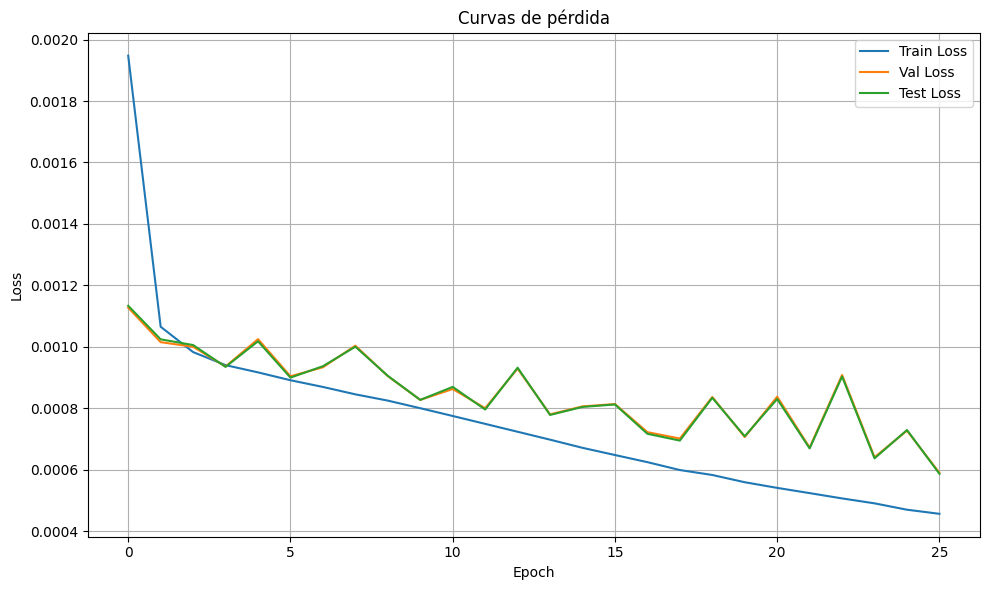

In [13]:
#Plot the loss curves of the second model
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curvas de pérdida")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def visualize_and_save_predictions(model, loader, n=5, title="Predictions", visualize=True):
    """
    Visualizes and returns model predictions on a dataset.
    Args:
        model: Trained model.
        loader: DataLoader with the data.
        n: Number of samples to visualize/save.
        title: Title for the visualization.
        visualize: If True, displays the images. If False, only saves predictions.
    
    Returns:
        List of predictions (numpy arrays).
    """
    model.eval()
    count = 0
    predictions = []

    with torch.no_grad():
        for skeleton, physique, pressure_gt, _ in loader:
            skeleton, physique = skeleton.to(device), physique.to(device)
            B = skeleton.size(0)
            physique_exp = physique.view(B, 2, 1, 1).expand(B, 2, 256, 256)
            x_input = torch.cat([skeleton, physique_exp], dim=1)
            pred = model(x_input).cpu().numpy()
            gt = pressure_gt.numpy()

            for i in range(B):
                predictions.append(pred[i][0])  # only channel 0

                if visualize:
                    plt.figure(figsize=(10, 8))  
                    plt.subplot(1, 2, 1)
                    plt.imshow(gt[i][0], cmap="jet", vmin=0, vmax=1, aspect='auto')
                    plt.title("Ground Truth")
                    plt.axis("off")

                    plt.subplot(1, 2, 2)
                    plt.imshow(pred[i][0], cmap="jet", vmin=0, vmax=1, aspect='auto')
                    plt.title("Prediction")
                    plt.axis("off")

                    plt.suptitle(f"{title} — Sample {count+1}")
                    plt.tight_layout()
                    plt.show()

                count += 1
                if count >= n:
                    return predictions

    return predictions


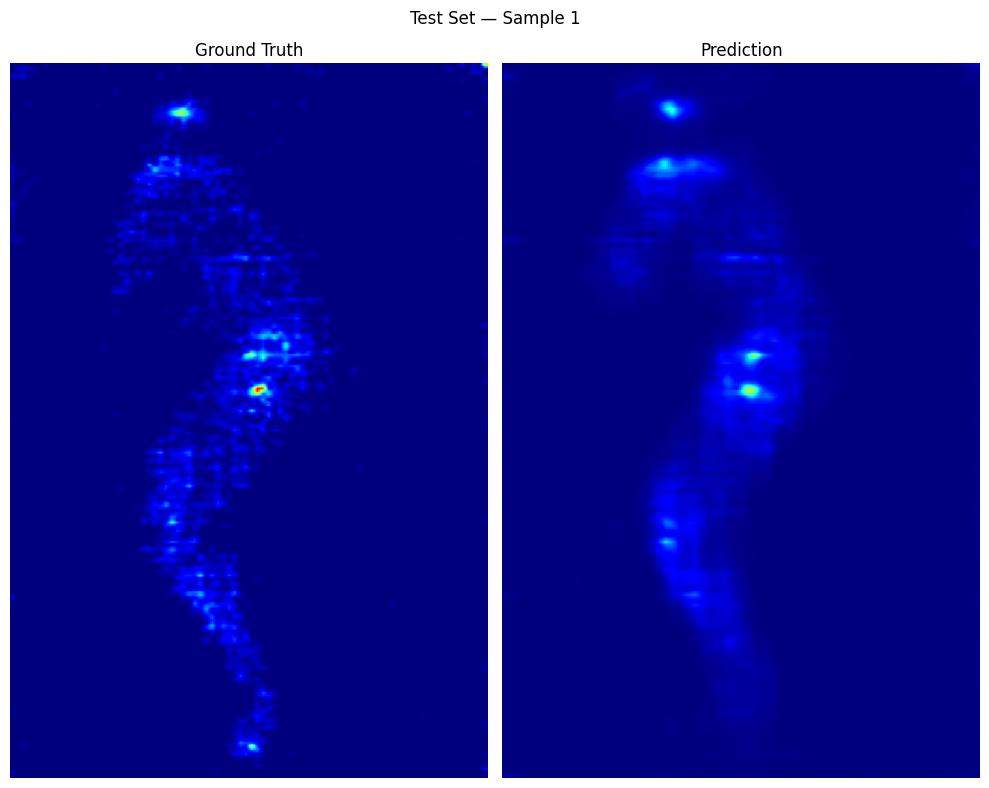

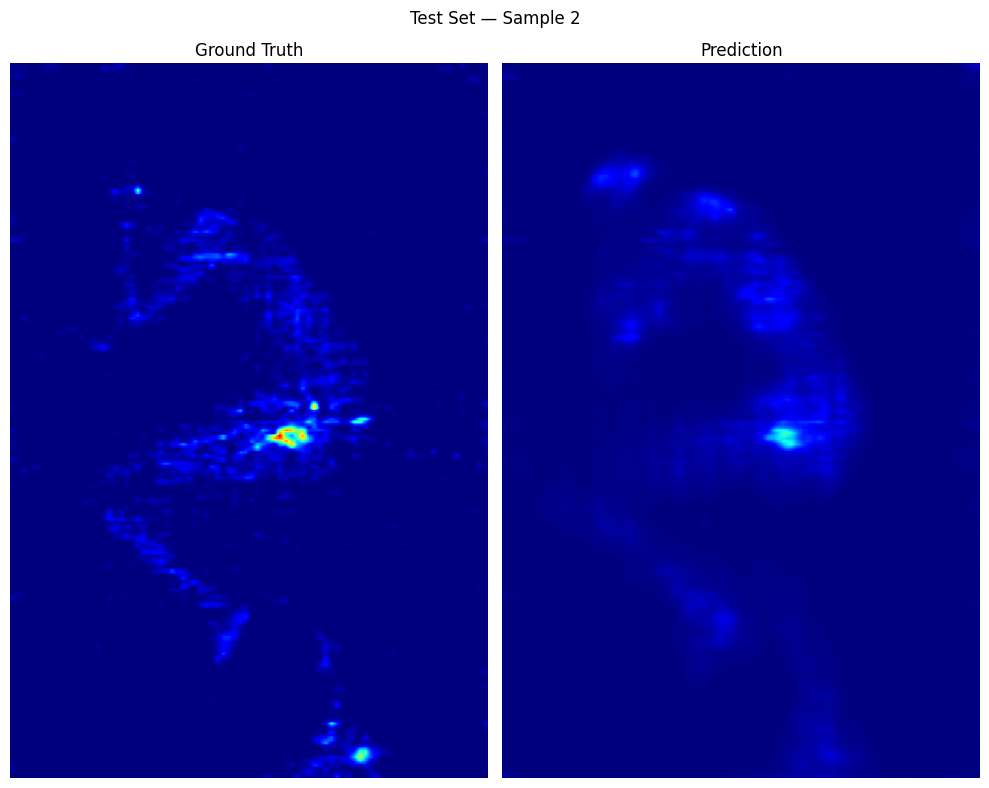

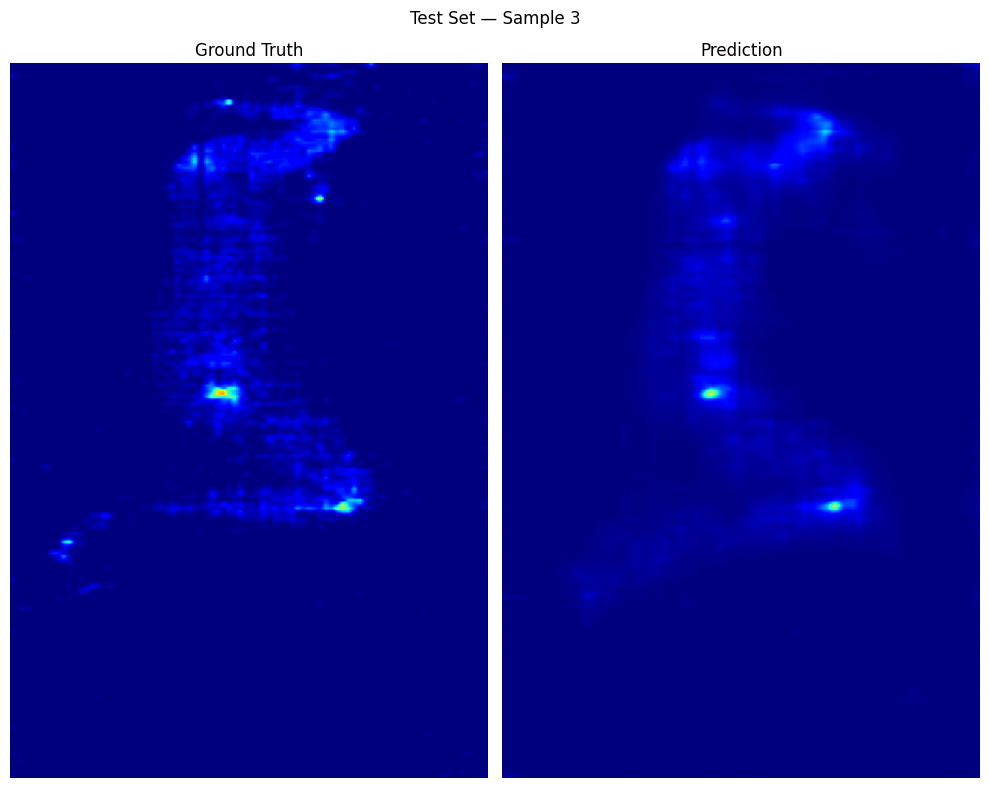

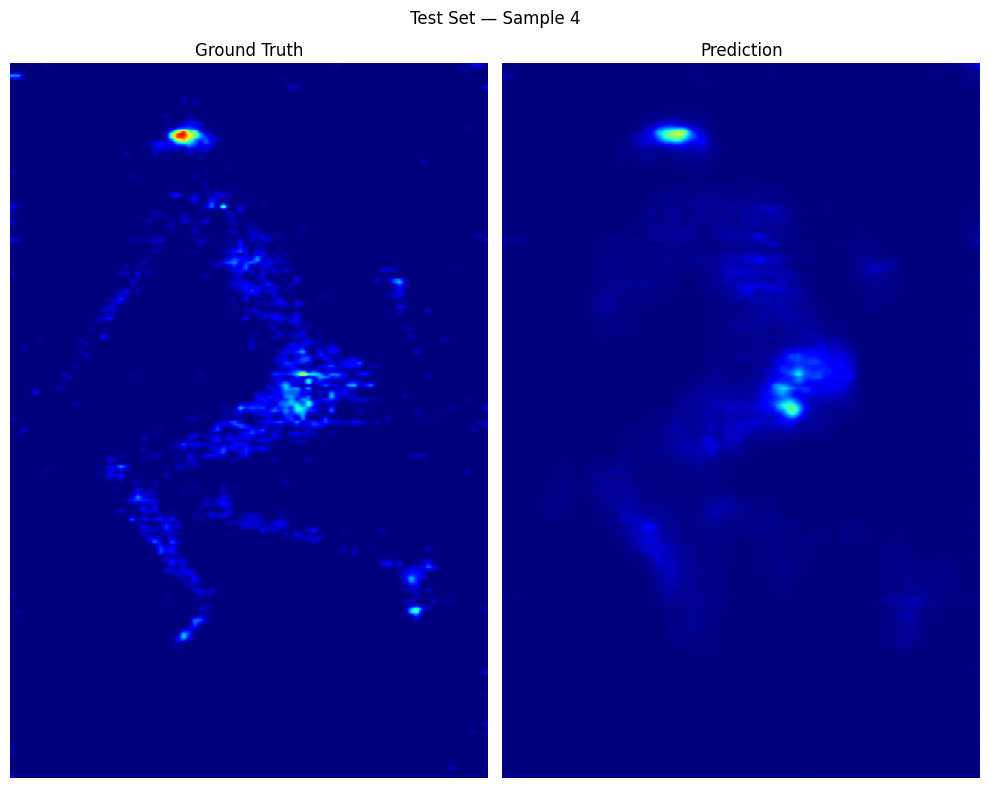

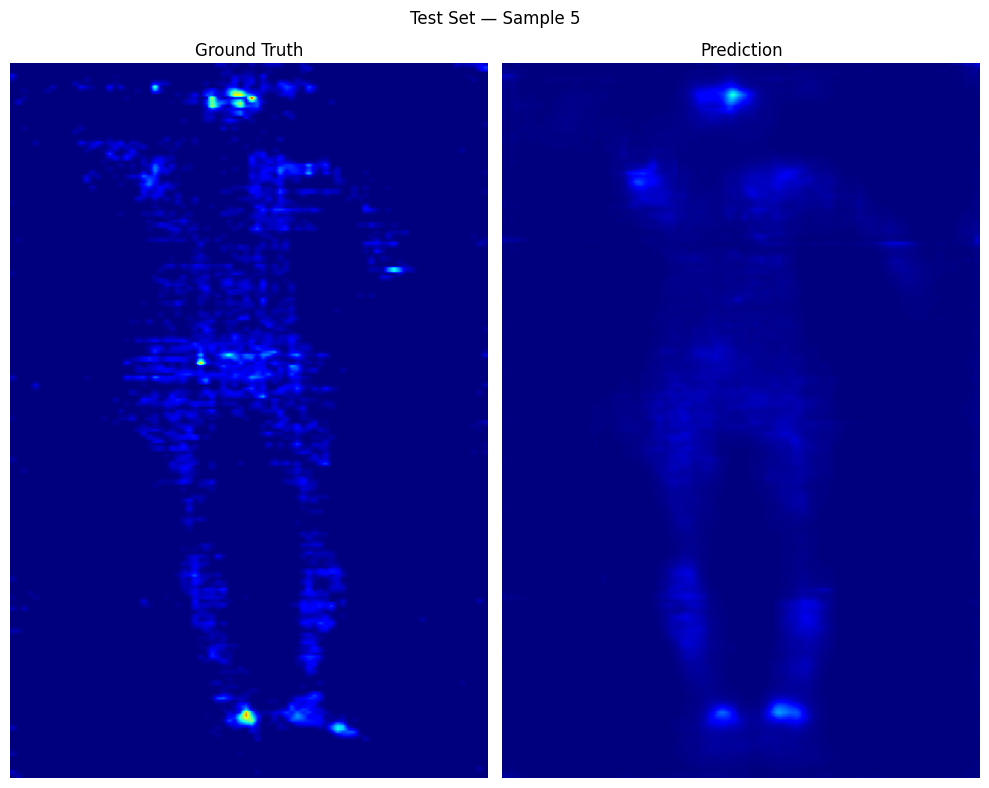

In [20]:
Test_preds = visualize_and_save_predictions(model_Unet, test_loader_2, n=5, title="Test Set")

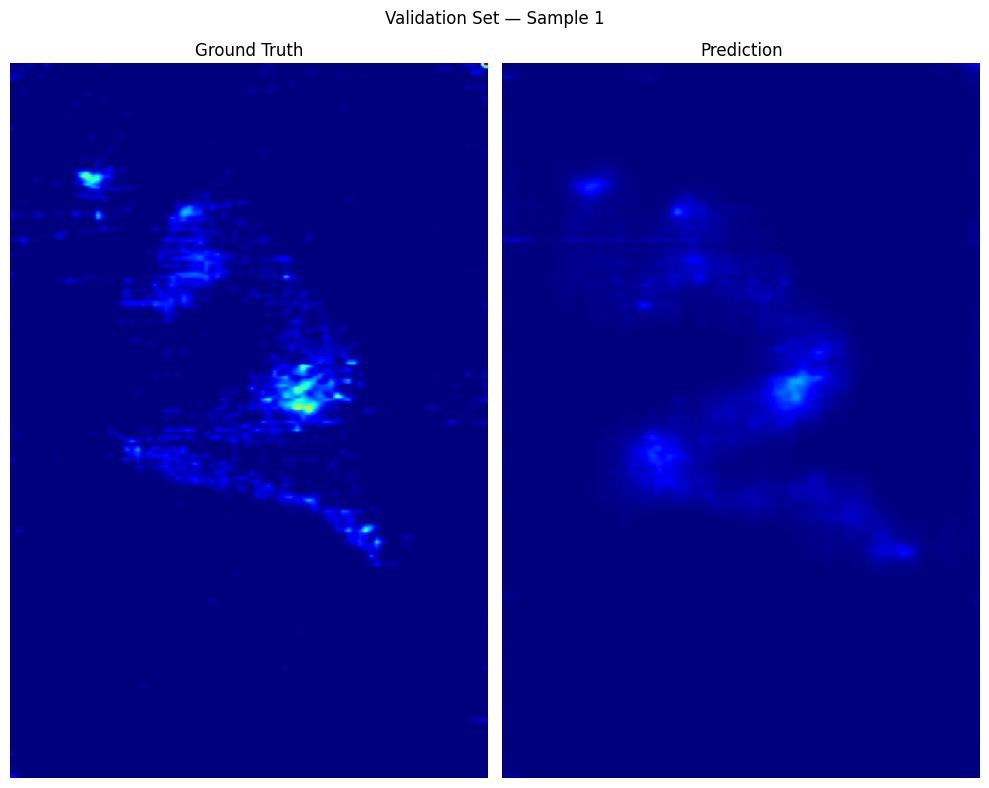

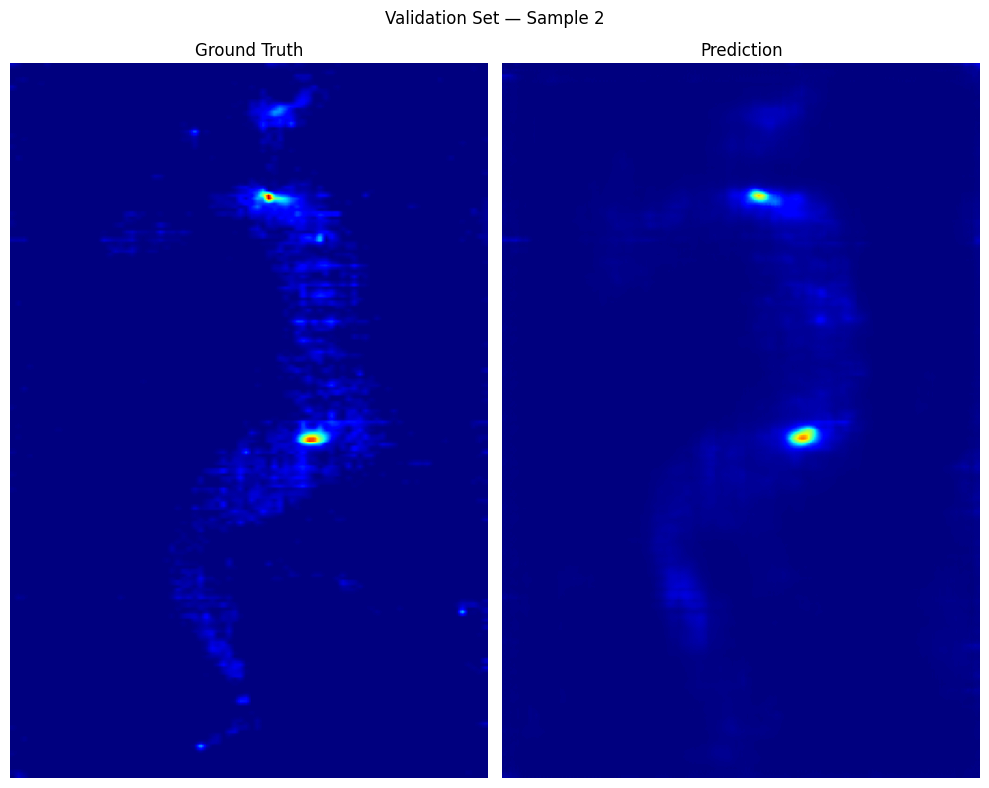

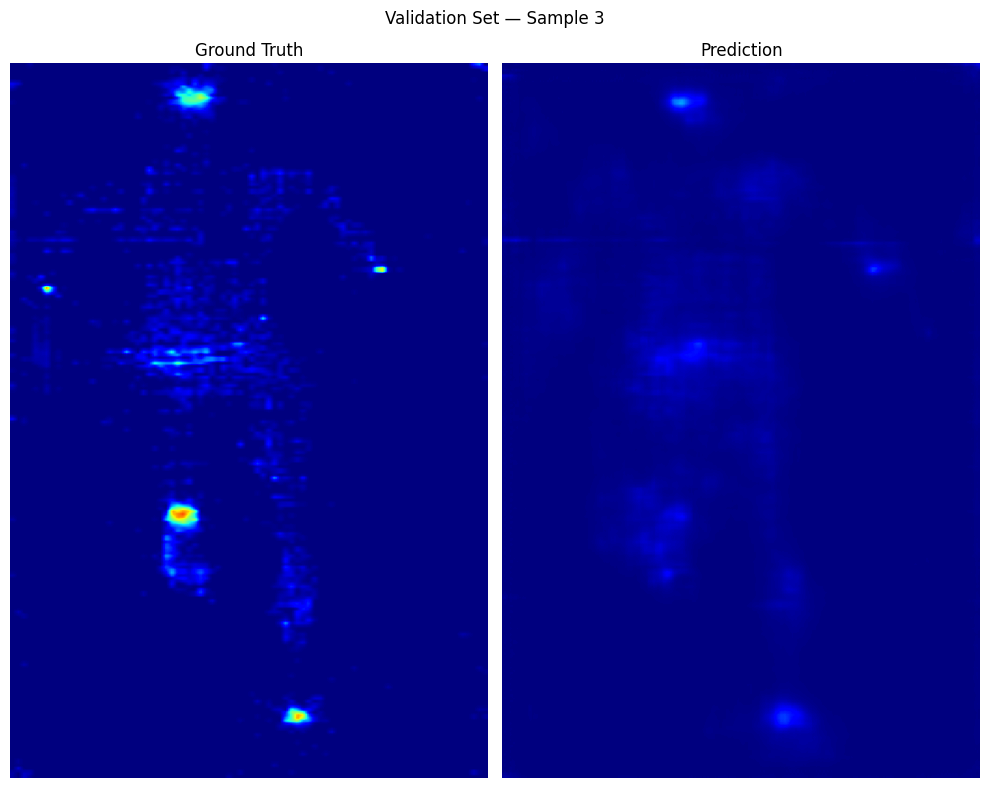

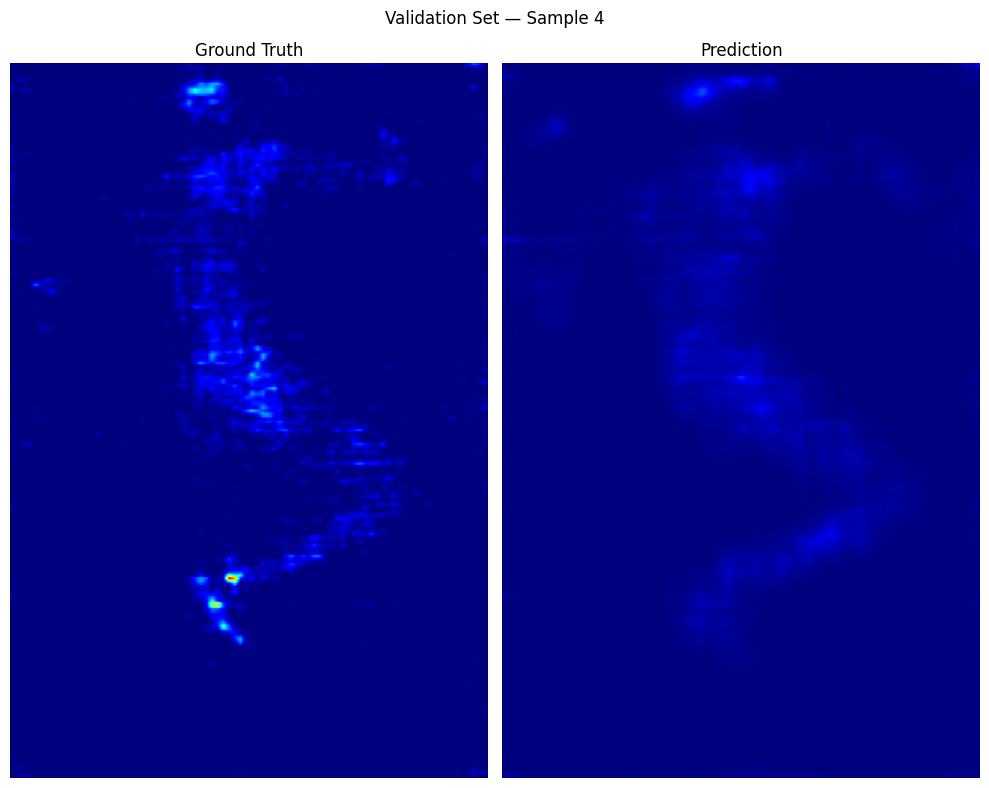

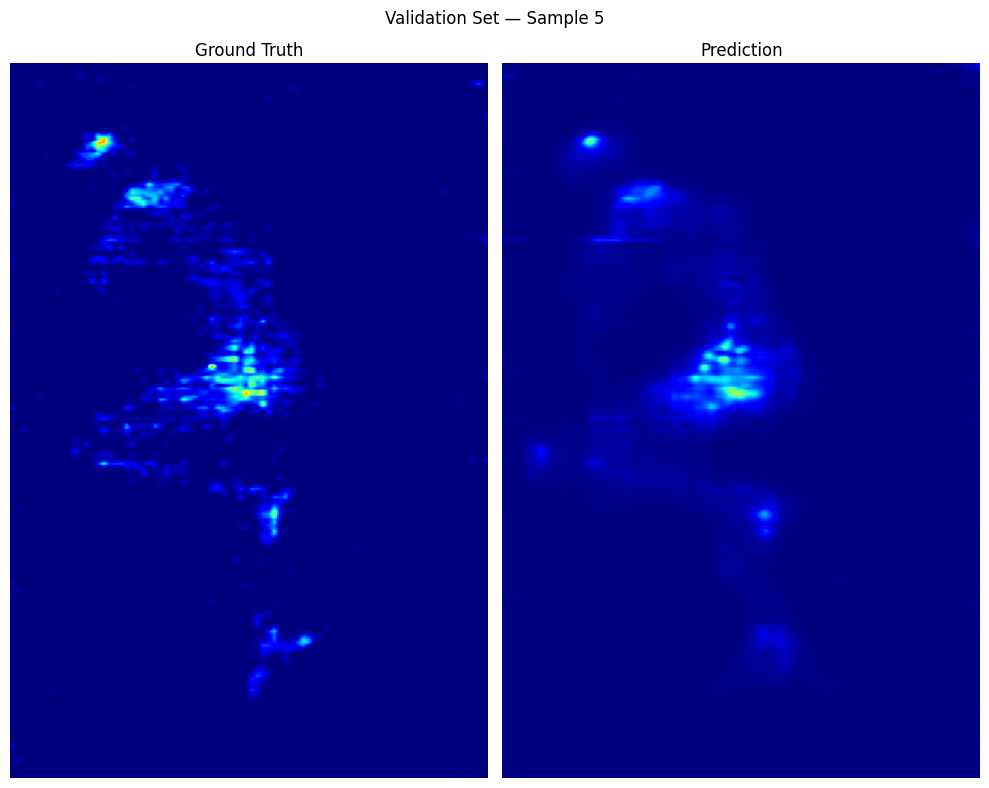

In [15]:
validation_preds = visualize_and_save_predictions(model_Unet, val_loader_2, n=5, title="Validation Set")

## 3D RECONSTRUCTION:

In [ ]:
def extract_joint_coordinates(heatmaps):
    """
    heatmaps: numpy array with shape (14, 256, 256)
    Returns: array of shape (14, 2) with coordinates (x, y)
    """
    coords = []
    for i in range(heatmaps.shape[0]):
        y, x = np.unravel_index(np.argmax(heatmaps[i]), heatmaps[i].shape)
        coords.append((x, y))  
    return np.array(coords)

In [31]:
def create_gif_with_joints(pred_pressure, joints_2d, filename='gif_silhouette_prediction.gif', normalize=True, scale=10, fps=15, duration=3):
    """
    Creates a rotating GIF with a 3D pressure map and overlaid joints.

    Args:
        pred_pressure (np.ndarray): 2D array representing the predicted pressure map.
        joints_2d (np.ndarray): Array of shape (J, 2) with 2D joint coordinates.
        filename (str): Output filename for the GIF.
        normalize (bool): Whether to normalize the pressure map.
        scale (float): Maximum height for the Z axis.
        fps (int): Frames per second for the GIF.
        duration (int): Duration of the GIF in seconds.

    Returns:
        None. Saves the GIF to the specified filename.
    """
    Z = pred_pressure.astype(np.float32)
    if normalize:
        Z = Z / np.max(Z + 1e-6) * scale
    Z_smooth = gaussian_filter(Z, sigma=3)
    Z_zoom = zoom(Z_smooth, zoom=2)

    rows, cols = Z_zoom.shape
    X, Y = np.meshgrid(np.linspace(0, cols, cols), np.linspace(0, rows, rows))

    # Scale joints to new size
    scale_factor = 2
    joints = joints_2d * scale_factor

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        ax.clear()
        ax.plot_surface(X, Y, Z_zoom, cmap='plasma', edgecolor='none', alpha=0.9)
        ax.set_zlim(0, scale)
        ax.axis('off')
        ax.view_init(elev=45, azim=frame)

    ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 360, fps * duration), blit=False)
    ani.save(filename, writer='pillow', fps=fps)
    plt.close()
    print(f"GIF generated: {filename}")

In [32]:
def detect_risk_zones_by_region(pred_map, joints_2d, threshold=0.8, window=20):
    """
    Detects complete body regions at risk of ulceration
    by evaluating a patch around the joints belonging to each region.

    Args:
        pred_map (np.ndarray): Pressure map (H, W)
        joints_2d (np.ndarray): Coordinates (14, 2)
        threshold (float): Pressure threshold
        window (int): Size of the square patch to evaluate

    Returns:
        List[str]: Names of regions at risk
    """
    regions = {
        "head": [13],
        "neck and shoulders": [12, 8, 9],  # neck, right and left shoulder
        "right arm": [6, 7],               # right elbow and wrist
        "left arm": [11, 10],              # left elbow and wrist
        "glutes": [2, 3],                  # right and left hip
        "right leg": [0, 1],               # right heel and knee
        "left leg": [4, 5],                # left heel and knee
    }

    risk_zones = []
    H, W = pred_map.shape
    half = window // 2

    for region, joint_idxs in regions.items():
        for idx in joint_idxs:
            x, y = joints_2d[idx]
            x, y = int(x), int(y)
            x1, x2 = max(0, x - half), min(W, x + half + 1)
            y1, y2 = max(0, y - half), min(H, y + half + 1)
            patch = pred_map[y1:y2, x1:x2]

            if np.any(patch > threshold):
                risk_zones.append(region)
                break  # if any joint is at risk, the region is at risk

    return risk_zones

In [ ]:
# Evaluate model and generate GIFs with warning
output_dir = "generated_gifs_5"
os.makedirs(output_dir, exist_ok=True)

model_Unet.eval()

with torch.no_grad():
    for idx, (skeleton, physique, _, _) in enumerate(tqdm(test_loader_2)):
        if idx >= len(Test_preds):
            break

        skeleton = skeleton.to(device)
        heatmaps = skeleton[0].cpu().numpy()  # shape: (14, 256, 256)
        joints_2d = extract_joint_coordinates(heatmaps)

        pred_pressure = Test_preds[idx]
        pred_norm = pred_pressure.astype(np.float32)

        # Detect risk zones
        risk_zones = detect_risk_zones_by_region(pred_norm, joints_2d, threshold=0.5, window=50)

        if risk_zones:
            print(f"Sample {idx}: Regions at risk of ulceration:", ", ".join(risk_zones))
        else:
            print(f"Sample {idx}: No regions with high risk detected.")

        # Save GIF
        output_path = os.path.join(output_dir, f"prediction_{idx}.gif")
        create_gif_with_joints(pred_norm, joints_2d, filename=output_path)

  0%|          | 0/345 [00:00<?, ?it/s]

Sample 0: Regions at risk of ulceration: head, left arm, glutes


  0%|          | 1/345 [00:13<1:19:48, 13.92s/it]

GIF generated: generated_gifs_5/prediction_0.gif
Sample 1: Regions at risk of ulceration: glutes


  1%|          | 2/345 [00:27<1:19:09, 13.85s/it]

GIF generated: generated_gifs_5/prediction_1.gif
Sample 2: Regions at risk of ulceration: right arm, glutes, left leg


  1%|          | 3/345 [00:41<1:18:14, 13.73s/it]

GIF generated: generated_gifs_5/prediction_2.gif
Sample 3: Regions at risk of ulceration: head, neck and shoulders, glutes


  1%|          | 4/345 [00:55<1:18:03, 13.74s/it]

GIF generated: generated_gifs_5/prediction_3.gif
Sample 4: No regions with high risk detected.


  1%|▏         | 5/345 [01:08<1:17:38, 13.70s/it]

GIF generated: generated_gifs_5/prediction_4.gif


### COMPUTE METRICS:

In [47]:
def evaluate_set(model, loader, name=str):
    """
    Evaluate the model on a given dataset and print the metrics.
    Args:
        model (torch.nn.Module): Trained model.
        loader (DataLoader): DataLoader for the dataset.
        name (str): Name of the dataset (e.g., "train", "val", "test").
    Returns:
        dict: Dictionary with mean MSE, MAE, and PSNR values.
    """
    model.eval()
    mse_list, mae_list, psnr_list = [], [], []

    with torch.no_grad():
        for skeleton, physique, pressure_gt, _ in loader:
            skeleton, physique, pressure_gt = skeleton.to(device), physique.to(device), pressure_gt.to(device)
            B = skeleton.size(0)
            physique_exp = physique.view(B, 2, 1, 1).expand(B, 2, 256, 256)
            x_input = torch.cat([skeleton, physique_exp], dim=1)
            pred = model(x_input).cpu().numpy()
            gt = pressure_gt.cpu().numpy()

            for i in range(B):
                pred_flat = pred[i].flatten()
                gt_flat   = gt[i].flatten()
                mse_list.append(mean_squared_error(gt_flat, pred_flat))
                mae_list.append(mean_absolute_error(gt_flat, pred_flat))
                psnr_list.append(psnr(gt[i][0], pred[i][0], data_range=1.0))

    print(f" Métricas en {name} set:")
    print(f" MSE  medio: {np.mean(mse_list):.6f}")
    print(f" MAE  medio: {np.mean(mae_list):.6f}")
    print(f" PSNR medio: {np.mean(psnr_list):.2f} dB")

    return {
        "set": name,
        "mse_mean": float(np.mean(mse_list)),
        "mae_mean": float(np.mean(mae_list)),
        "psnr_mean": float(np.mean(psnr_list)),
    }

In [48]:
metrics_val = evaluate_set(model_Unet, val_loader_2, name="validation")
print("")
metrics_test = evaluate_set(model_Unet, test_loader_2, name="test")

 Métricas en validation set:
 MSE  medio: 0.000589
 MAE  medio: 0.008259
 PSNR medio: 32.81 dB

 Métricas en test set:
 MSE  medio: 0.000586
 MAE  medio: 0.008249
 PSNR medio: 32.87 dB


The results show very stable and accurate performance on both the validation and test sets. The mean squared error (MSE) is practically the same for both sets (0.000589 for validation and 0.000586 for test), indicating that the model has not overfitted and generalizes well to new data.
The mean absolute error (MAE) is around 0.0082, meaning the differences between the real and predicted pressure maps are very small. Additionally, the PSNR (related to the visual quality of the prediction) exceeds 32.8 dB in both cases, confirming that the model’s predictions are visually very similar to the real images.